# 2020-in-my-trello

Here I load my Trello data and produce the figure that serves as base for `2020_dataviz.svg`.

In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set('talk')
sns.set_style('whitegrid')

# 1. Load and examine Trello data

In [2]:
infile = '2020.json' # Downloaded from my Trello

with open(infile) as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['id', 'name', 'desc', 'descData', 'closed', 'idOrganization', 'shortLink', 'powerUps', 'dateLastActivity', 'idTags', 'datePluginDisable', 'creationMethod', 'idBoardSource', 'idMemberCreator', 'idEnterprise', 'pinned', 'starred', 'url', 'shortUrl', 'enterpriseOwned', 'premiumFeatures', 'ixUpdate', 'limits', 'prefs', 'subscribed', 'templateGallery', 'dateLastView', 'labelNames', 'actions', 'cards', 'labels', 'lists', 'members', 'checklists', 'customFields', 'memberships', 'pluginData'])

In [4]:
data['labelNames']

{'green': 'Papers',
 'yellow': 'Admin',
 'orange': 'Career / Bids',
 'red': 'Art',
 'purple': 'Teaching/Supervising',
 'blue': 'Public engagement',
 'sky': '',
 'lime': '',
 'pink': '',
 'black': ''}

In [5]:
len(data['lists'])

52

In [6]:
lists_id_to_name = { l['id']:l['name'] for l in data['lists'] }
lists_name_to_id = { l['name']:l['id'] for l in data['lists'] }

In [7]:
len(data['actions'])

1000

In [8]:
len(data['cards'])

2191

In [239]:
idx = 610
card = data['cards'][idx]

print('The card', card['name'])
print('was last edited in', card['dateLastActivity'])
print('is in list',lists_id_to_name[card['idList']])

print(f'And has labels:', end=' ')
print(', '.join([ label['name'] for label in card['labels'] ]))

The card Prepare for 11am meeting
was last edited in 2020-04-30T15:42:37.703Z
is in list Done! 03-05-2020
And has labels: Admin


In [10]:
labels2colours = {'Papers': '#61BD4F',
                  'Admin':'#F2D600',
                  'Career / Bids':'#FFAB4A',
                  'Art':'#EB5A46',
                  'Teaching/Supervising':'#C377E0',
                  'Public engagement':'#0079BF'}

n_labels = len(labels2colours)

In [11]:
from matplotlib.colors import LinearSegmentedColormap

colors = list(labels2colours.values())
cmap   = LinearSegmentedColormap.from_list('my_cmap', colors, N=len(colors))    

In [12]:
all_list_names = lists_id_to_name.values()
all_cards = data['cards']

In [13]:
all_weeks_str = [ name[6:] for name in all_list_names if 'Done!' in name ]

all_weeks_dt  = np.array([ datetime.strptime(d, "%d-%m-%Y") for d in all_weeks_str ])

sort_weeks_idx = np.argsort(all_weeks_dt)

In [14]:
list_name_to_labels = {}

for card in all_cards:
    list_name = lists_id_to_name[card['idList']]
    
    if 'Done' in list_name:
        if list_name not in list_name_to_labels:
            list_name_to_labels[list_name] = { label:0 for label in labels2colours }
            
        for label in card['labels']:
            label_name = label['name']
                       
            list_name_to_labels[list_name][label_name] += 1      

In [15]:
week_to_labels = { datetime.strptime(k[6:], "%d-%m-%Y"):v for k,v in list_name_to_labels.items() }

In [16]:
df_all_labels = pd.DataFrame(week_to_labels).T.sort_index()

In [17]:
df_all_labels.sum(axis=0)

Papers                  742
Admin                   922
Career / Bids           238
Art                       7
Teaching/Supervising    115
Public engagement       121
dtype: int64

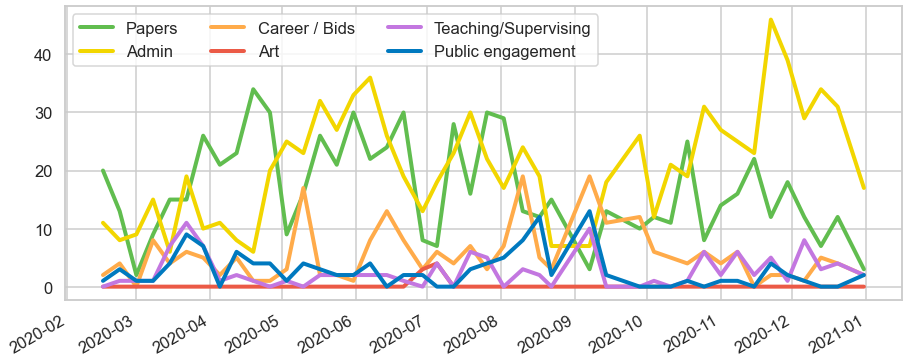

In [18]:
fig, ax = plt.subplots(figsize=(15,6))

df_all_labels[df_all_labels.columns].plot(ax=ax, lw=4, cmap=cmap)

plt.legend(ncol=3)

plt.show()

In [19]:
df_normalised_weeks = (df_all_labels.T/ df_all_labels.T.sum(axis=0)).T

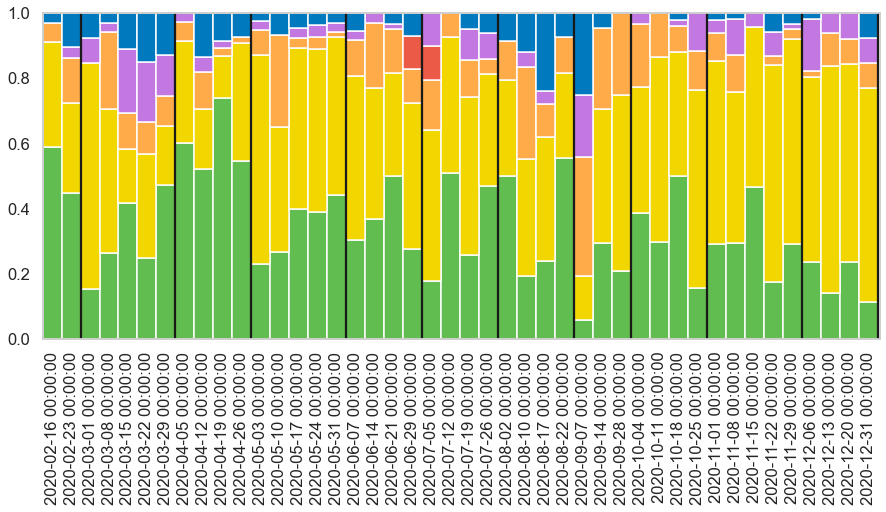

In [20]:
fig, ax = plt.subplots(figsize=(15,6))

df_normalised_weeks.plot.bar(ax=ax, stacked=True, width=1, cmap=cmap)

month_dividers = [1.5, 6.5, 10.5, 15.5, 19.5, 23.5, 27.5, 30.5, 34.5, 39.5, 43.5]
for x in month_dividers:
    ax.axvline(x, c='k')

ax.set_xlim(-0.5,43.6)
ax.set_ylim(0,1)
ax.get_legend().remove()
plt.show()

In [22]:
df_all_labels.sum(axis=0)

Papers                  742
Admin                   922
Career / Bids           238
Art                       7
Teaching/Supervising    115
Public engagement       121
dtype: int64

# Make final plot

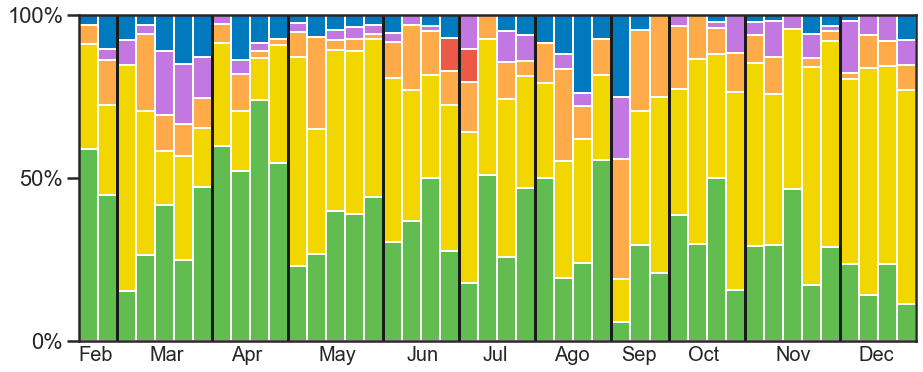

In [165]:
sns.set('poster')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(15,6))

month_dividers = np.array([1.5, 6.5, 10.5, 15.5, 19.5, 23.5, 27.5, 30.5, 34.5, 39.5])
for x in month_dividers:
    ax.axvline(x, c='k')

df_normalised_weeks.plot.bar(ax=ax, stacked=True, width=1, cmap=cmap)
  
ax.set_xlim(-0.5,43.5)
ax.set_ylim(0,1)
ax.get_legend().remove()
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0%','50%','100%'])
ax.set_xticks([])

fontsize = 20
months   = ['Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']
x_months = month_dividers - 2
x_months = [-0.5, 3.2, 7.5, 12.1, 16.7, 20.7, 24.5, 28.0, 31.5, 36.1, 40.5]
y_months = [-0.06]*11

for m,x,y in zip(months,x_months,y_months):
    ax.text(x,y,m,fontsize=fontsize)

plt.savefig('base_plot.svg')    
plt.show()